<a href="https://colab.research.google.com/github/luisdiaz1997/DataScienceCourse/blob/master/FastMonkeys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#We want to delete the current Pytorch and reinstall torch ==1.4.0

In [1]:
!pip uninstall torch torchvision -y
!pip install torch==1.4.0 torchvision==0.5.0

Uninstalling torch-1.5.0+cu101:
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 38.7MB/s 


##import FastAI

In [0]:
import fastai
from fastai.vision import *

## Set up Kaggle

In [0]:
! pip install -q kaggle
! mkdir ~/.kaggle

## Put your Json file into files then run the following block

In [0]:
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#We will be using the 10 monkeys dataset

In [5]:
! kaggle datasets download -d slothkong/10-monkey-species

 99% 539M/547M [00:09<00:00, 54.8MB/s]
100% 547M/547M [00:09<00:00, 57.8MB/s]


## We want to unzip the data

In [0]:
!unzip 10-monkey-species.zip

## We load the data from folder, we use test as our validation given that val only contains 16 images, and test contains 624

### We also transform it into a 256 x 256, and select a batch size of 64, also apply some transfomations for data augmentation and normalize the data with parameters used for the image_net dataset


In [25]:
data = ImageDataBunch.from_folder(path = '/content/', train = 'training', 
                                  valid = 'validation', 
                                  size=256,bs=64, ds_tfms=get_transforms()).normalize(imagenet_stats)
data

ImageDataBunch;

Train: LabelList (1097 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
n0,n0,n0,n0,n0
Path: /content;

Valid: LabelList (272 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
n0,n0,n0,n0,n0
Path: /content;

Test: None

## Proceed to create a label_dict, to just for us to display the images later

In [26]:
label_dict = dict()
for key, val in data.label_list.train.y.c2i.items():
  label_dict[val] = key

label_dict

{0: 'n0',
 1: 'n1',
 2: 'n2',
 3: 'n3',
 4: 'n4',
 5: 'n5',
 6: 'n6',
 7: 'n7',
 8: 'n8',
 9: 'n9'}

## FastAi has this .show_batch() which lets you explore the internals of your data

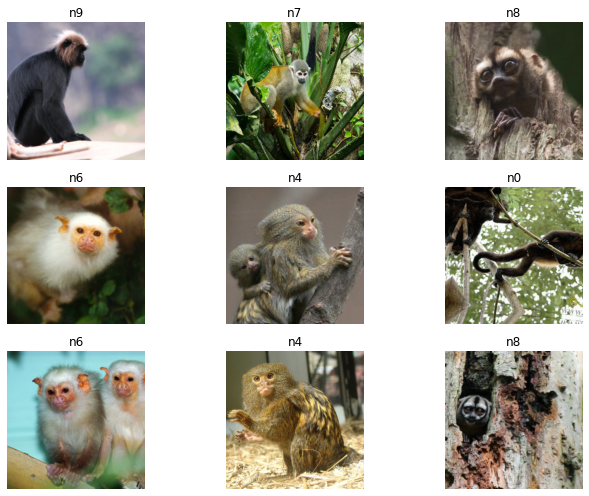

In [27]:
data.show_batch(3, figsize=(10,7));

#We try to load the learner first, if available, otherwise we can just create a new one.

### This model will be using Resnet34, but you can try other popular pretrained networks

### We also make use of AUROC score, since accuracy is not necessarily a good metric, AUROC takes into account false positives and true positives for score calculation

In [28]:
try:
  
  learn = load_learner(path = '/content/', file = 'net')
  learn.data = data
  print("model imported")
except:
  learn = cnn_learner(data, models.resnet34, 
                   metrics=[accuracy, AUROC()],
                   model_dir='/content/')
  print("created new model")

created new model


## We first find the learning rate with the he lowest slope, meaning that this one will contain the minimum gradient.

In [29]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.20E-03
Min loss divided by 10: 1.74E-02


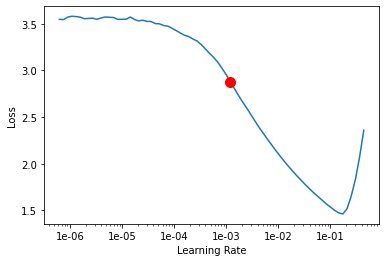

In [30]:
learn.recorder.plot(suggestion= True)

In [31]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

## We train for 6 cycles

In [32]:
learn.fit_one_cycle(6, 1.20E-03)

epoch,train_loss,valid_loss,accuracy,auroc,time
0,2.574676,0.504221,0.889706,0.386563,01:02
1,1.291389,0.034580,0.992647,0.586651,01:03
2,0.779769,0.022928,0.992647,0.585187,01:02
3,0.502912,0.022375,0.988971,0.563964,01:03
4,0.346862,0.021051,0.992647,0.596019,01:03
5,0.254810,0.020348,0.992647,0.583577,01:03


## We save the model

### I called it dense, but feel free to use any other name

In [0]:
learn.export('/content/net')

## Optional, you can also UNFREEZE the model, so it trains all the layers, not only the latest ones. This is useful to finetune your model

In [0]:
learn.unfreeze()

In [36]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 128, 128]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 128, 128]       128        True      
______________________________________________________________________
ReLU                 [64, 128, 128]       0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 64]         0          False     
______________________________________________________________________
Conv2d               [64, 64, 64]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
___________________________________________________

In [37]:
learn.fit_one_cycle(3, slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,auroc,time
0,0.063515,0.022395,0.988971,0.575966,01:03
1,0.052798,0.015866,0.996324,0.633636,01:03
2,0.054526,0.014676,1.000000,0.637149,01:04


## At this point you should get from 98% to 100% accuracy

## Let's take a look at how the bad predictions look like, along with their heatmaps

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()

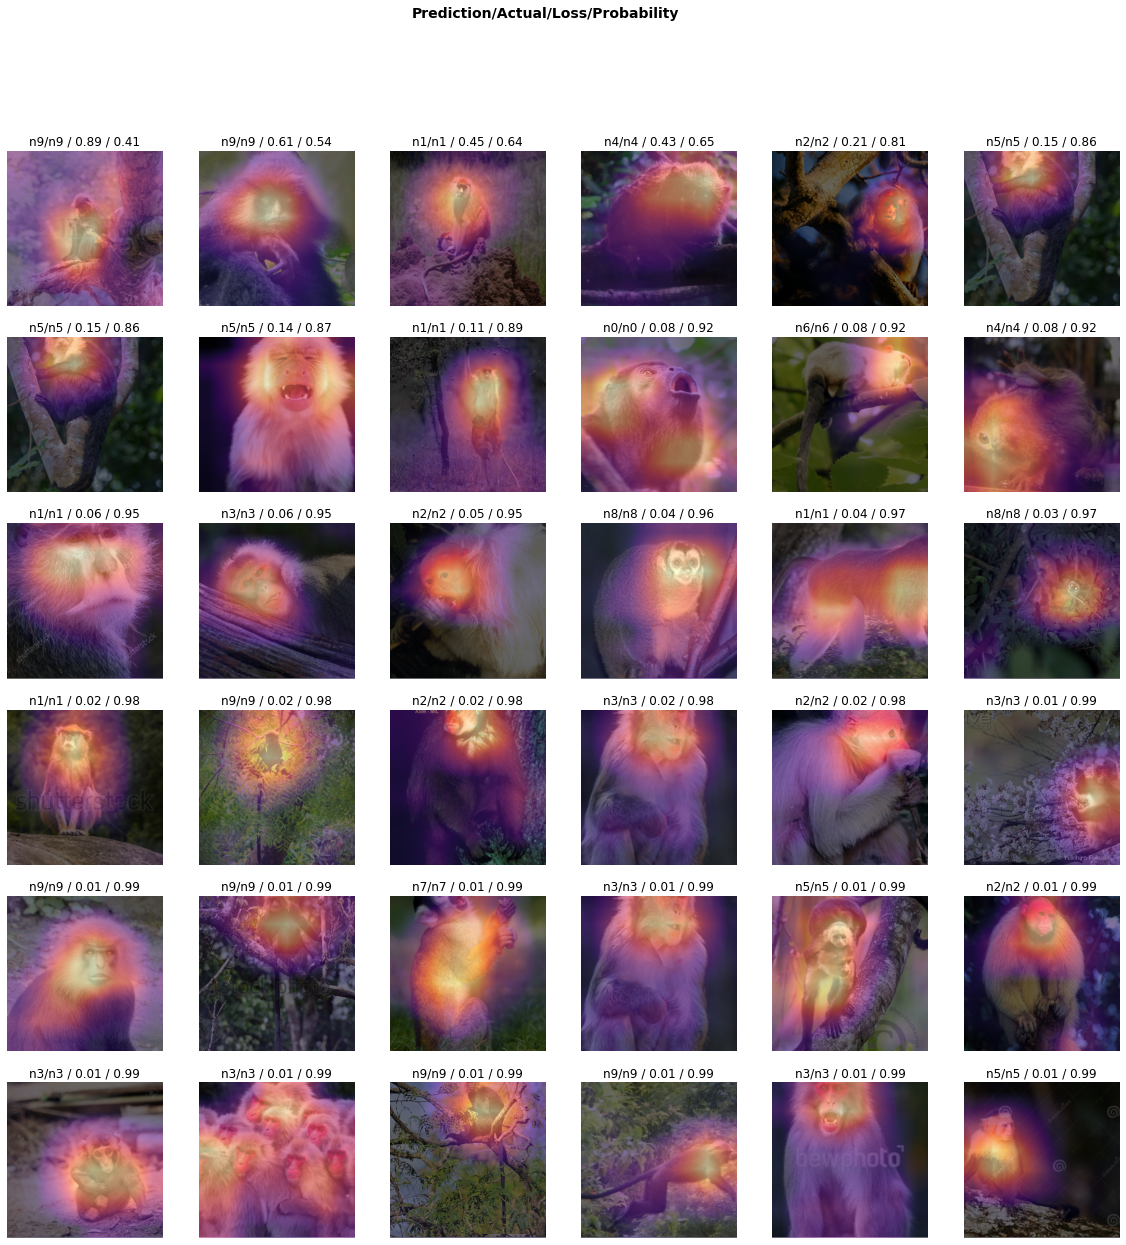

In [46]:
interp.plot_top_losses(36, figsize=(20,20), heatmap = True)

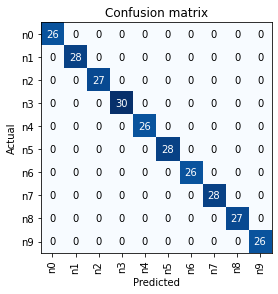

In [49]:
interp.plot_confusion_matrix()